# Airbnb Project

### Content
The following Airbnb activity is included in this Seattle dataset:

- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

### Inspiration
- Can you describe the vibe of each Seattle neighborhood using listing descriptions?
- What are the busiest times of the year to visit Seattle? By how much do prices spike?
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

### My questions

- Pricing model: Can I perform a prognose of the price of the apartment based on location, properties (frunishment, rooms, sqm, etc.), time, ... ? NaN Values of available = f can be transformed to 0 to take into account that the it was not taken
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

### Import of libraries and data

In [871]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

# Import files
df_calendar = pd.read_csv('./data/archive/calendar.csv')
df_listings = pd.read_csv('./data/archive/listings.csv')
df_reviews = pd.read_csv('./data/archive/reviews.csv')

print(df_listings.shape)
print(df_calendar.shape)
print(df_reviews.shape)

#Rename column
df_listings.rename(columns={'id': 'listing_id'}, inplace=True)
df_listings.rename(columns={'price': 'price_room'}, inplace=True)
#Would rather use that for a LLM-Anaylsis
#df_reviews["date"] = pd.to_datetime(df_reviews["date"], format='%Y-%m-%d')

df_vec = [df_calendar, df_listings, df_reviews]

pd.set_option('display.max_columns', None)

df_calendar["date"] = pd.to_datetime(df_calendar["date"], format='%Y-%m-%d')
df_listings["host_since"] = pd.to_datetime(df_listings["host_since"], format='%Y-%m-%d')

# Converting the $-Values from String to Float:
df_calendar["price"] = df_calendar["price"].astype(str).str.replace("$", "").str.replace(",", "").astype(float)
#df_listings['weekly_price'] = df_listings['weekly_price'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)

dollars = ["price_room", "security_deposit", "cleaning_fee", "extra_people"]
for dollar in dollars:
    df_listings[dollar] = df_listings[dollar].astype(str).str.replace("$", "").str.replace(",", "").astype(float)


#df_cal_list = pd.merge(df_calendar, df_listings, how='inner', left_on='listing_id', right_on='listing_id')
#df_cal_list["price"] = df_cal_list["price"].fillna(0)
#df_cal_list = df_cal_list.dropna(subset=['price'], axis=0)
#df_listings = df_listings.dropna(axis=1)

#Separation into relevant numeric and categoric data
df_cal_list_num = df_listings[["price_room","accommodates", "bathrooms", "bedrooms", "beds", "guests_included", "minimum_nights", "maximum_nights", "security_deposit", "cleaning_fee", "extra_people"]]
#df_listings_cat = df_listings.select_dtypes(include=["object"])
df_cal_list_cat = df_listings[["property_type", "room_type", "bed_type", "cancellation_policy", "require_guest_profile_picture", "require_guest_phone_verification", "instant_bookable"]]


df_new = pd.concat([df_cal_list_num, df_cal_list_cat], axis =1)
df_new = df_new.dropna()

df_new.head()

(3818, 92)
(1393570, 4)
(84849, 6)


,price_room,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,security_deposit,cleaning_fee,extra_people,property_type,room_type,bed_type,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,instant_bookable
1,150.0,4,1.0,1.0,1.0,1,2,90,100.0,40.0,0.0,Apartment,Entire home/apt,Real Bed,strict,t,t,f
2,975.0,11,4.5,5.0,7.0,10,4,30,1000.0,300.0,25.0,House,Entire home/apt,Real Bed,strict,f,f,f
4,450.0,6,2.0,3.0,3.0,6,1,1125,700.0,125.0,15.0,House,Entire home/apt,Real Bed,strict,f,f,f
7,60.0,2,1.0,1.0,1.0,1,2,7,150.0,25.0,0.0,Cabin,Private room,Real Bed,strict,t,t,f
9,150.0,4,1.0,1.0,1.0,1,2,365,100.0,40.0,0.0,Apartment,Entire home/apt,Real Bed,strict,t,t,f


<Axes: >

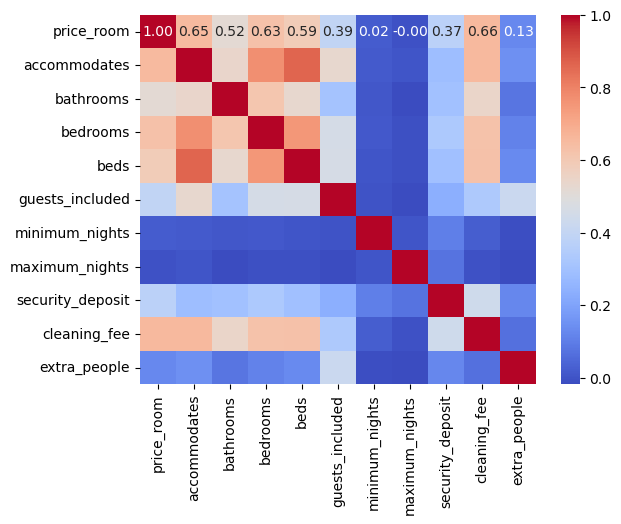

In [839]:
df_listings_corr_matrix = df_cal_list_num.corr()
sns.heatmap(df_listings_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

### How did unique listings change over time ?
Notes:
- The value is constant over a year, probably meaning, that listings that did not exist yet were included with their id while the value of availability was set to "f" and price to NaN to keep the total amount of listings constant over time

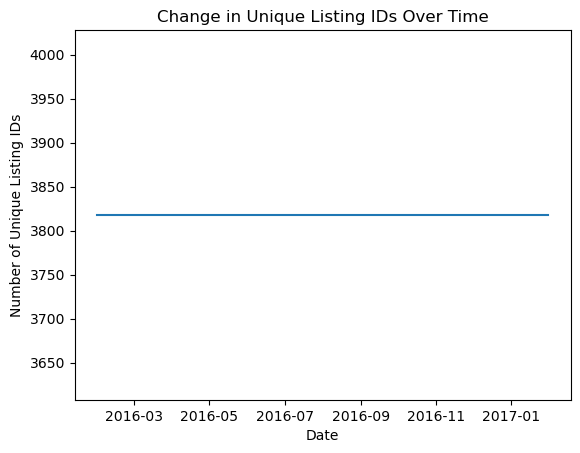

In [720]:
unique_listings_over_time = df_calendar.resample('M', on='date')['listing_id'].nunique()
unique_listings_over_time

plt.plot(unique_listings_over_time.index, unique_listings_over_time.values)
plt.xlabel('Date')
plt.ylabel('Number of Unique Listing IDs')
plt.title('Change in Unique Listing IDs Over Time')
plt.show()

### How did the occupancy rate change over time ?
Notes:
- It looks like the amount of people coming to Seattle to stay at Airbnbs is increasing over time, while there has been a drop in mid 2016

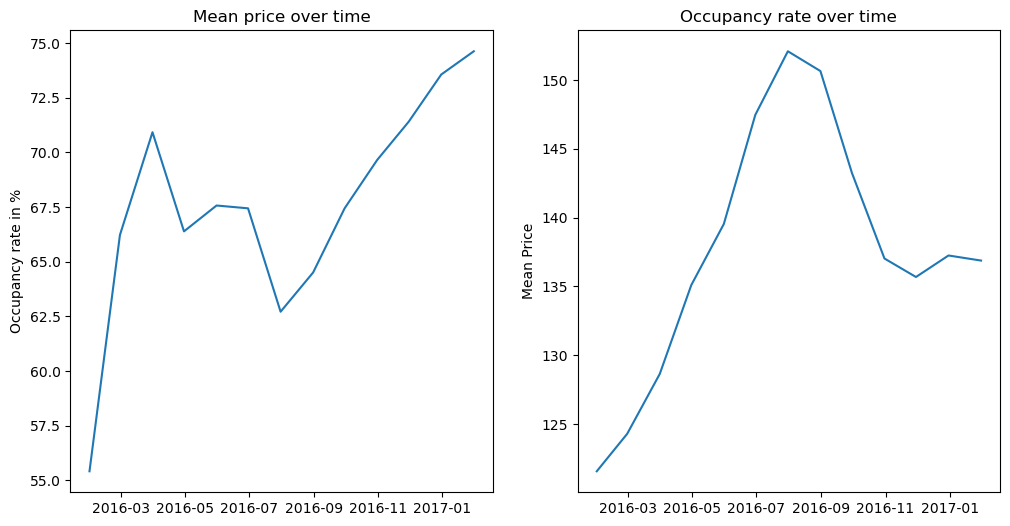

In [841]:
df_monthly_occup_ratio = df_calendar.resample('M', on='date')['available'].apply(lambda x: (x == 't').sum() / len(x) * 100)
df_monthly_mean_price = df_calendar_t[["price","date"]].resample('M', on="date").mean()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df_monthly_occup_ratio.index, df_monthly_occup_ratio.values)
plt.ylabel("Occupancy rate in %")
plt.title("Mean price over time")

plt.subplot(1, 2, 2)
plt.plot(df_monthly_mean_price.index, df_monthly_mean_price['price'])
plt.ylabel('Mean Price')
plt.title("Occupancy rate over time")

plt.show()

In [843]:
df_calendar_f = df_calendar[df_calendar["available"] == "f"]
df_calendar_t = df_calendar[df_calendar["available"] == "t"]
df_calendar_NaNfill = df_calendar.fillna(0)
df_calendar_f.isnull().sum()/df_calendar.shape[0]

# "available" = "f" means that the place was not booked and therefore there is no price data
# It would be interesting to see the ratio of f/t over time --> Think about a plot here

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

### Checking for NaN

In [846]:
for df in df_vec:
    print(df.shape)
    #print(df.dtypes)
    print(df.isnull().sum()/df.shape[0])
    print("------------")

(1393570, 4)
listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64
------------
(3818, 92)
listing_id                          0.000000
listing_url                         0.000000
scrape_id                           0.000000
last_scraped                        0.000000
name                                0.000000
                                      ...   
cancellation_policy                 0.000000
require_guest_profile_picture       0.000000
require_guest_phone_verification    0.000000
calculated_host_listings_count      0.000000
reviews_per_month                   0.164222
Length: 92, dtype: float64
------------
(84849, 6)
listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.000212
dtype: float64
------------


## Analysis of the mean price over time of booked airbnbs ("available" = "t") in calendar data

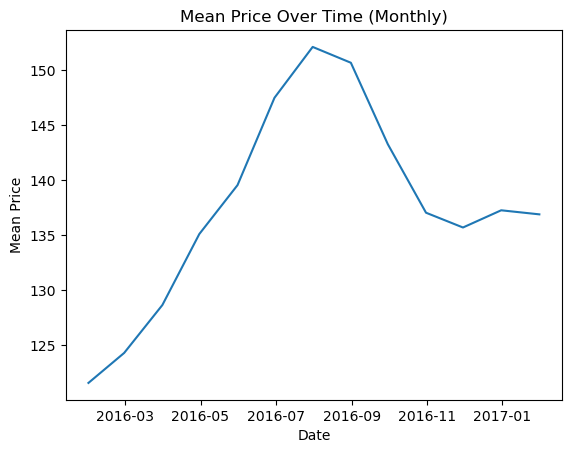

In [849]:
# Downsampling data by taking mean over Month "M" or Day "D"
df_downsampled = df_calendar_t[["price","date"]].resample('M', on="date").mean()

# Plotting the downsampled data
plt.plot(df_downsampled.index, df_downsampled['price'])
plt.xlabel('Date')
plt.ylabel('Mean Price')
plt.title('Mean Price Over Time (Monthly)')
plt.show()

In [851]:
#Pull a list of the column names of the categorical variables
cat_cols_lst = df_cal_list_cat.columns

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [853]:
df_new.isnull().sum()

price_room                             0
accommodates                           0
bathrooms                             16
bedrooms                               6
beds                                   1
guests_included                        0
minimum_nights                         0
maximum_nights                         0
security_deposit                    1952
cleaning_fee                        1030
extra_people                           0
property_type                          1
room_type                              0
bed_type                               0
cancellation_policy                    0
require_guest_profile_picture          0
require_guest_phone_verification       0
instant_bookable                       0
dtype: int64

In [867]:
df_new = create_dummy_df(df_new, df_cal_list_cat, dummy_na=False)
print(df_new)

# Fill the mean
#fill_mean = lambda col: col.fillna(col.mean())
#fill_df = drop_sal_df.apply(fill_mean, axis=0)

#Split into explanatory and response variables
y = df_new.pop("price_room")
X = df_new

X.isnull().sum()

      price_room  accommodates  bathrooms  bedrooms  beds  guests_included  \
1          150.0             4        1.0       1.0   1.0                1   
2          975.0            11        4.5       5.0   7.0               10   
4          450.0             6        2.0       3.0   3.0                6   
7           60.0             2        1.0       1.0   1.0                1   
9          150.0             4        1.0       1.0   1.0                1   
...          ...           ...        ...       ...   ...              ...   
3808       175.0             6        2.0       3.0   3.0                4   
3810       154.0             5        1.0       2.0   3.0                4   
3814        79.0             4        1.0       1.0   2.0                3   
3815        93.0             2        1.0       1.0   1.0                2   
3816        99.0             2        1.0       0.0   1.0                1   

      minimum_nights  maximum_nights  security_deposit  cleanin

accommodates                          0
bathrooms                             0
bedrooms                              0
beds                                  0
guests_included                       0
minimum_nights                        0
maximum_nights                        0
security_deposit                      0
cleaning_fee                          0
extra_people                          0
property_type_Bed & Breakfast         0
property_type_Boat                    0
property_type_Bungalow                0
property_type_Cabin                   0
property_type_Camper/RV               0
property_type_Condominium             0
property_type_House                   0
property_type_Loft                    0
property_type_Other                   0
property_type_Townhouse               0
property_type_Yurt                    0
room_type_Private room                0
room_type_Shared room                 0
bed_type_Couch                        0
bed_type_Futon                        0


In [760]:
X.head()

,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,security_deposit,cleaning_fee,extra_people,property_type,room_type,bed_type,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,instant_bookable
365,4,1.0,1.0,1.0,1,2,90,100.0,40.0,0.0,Apartment,Entire home/apt,Real Bed,strict,t,t,f
366,4,1.0,1.0,1.0,1,2,90,100.0,40.0,0.0,Apartment,Entire home/apt,Real Bed,strict,t,t,f
370,4,1.0,1.0,1.0,1,2,90,100.0,40.0,0.0,Apartment,Entire home/apt,Real Bed,strict,t,t,f
371,4,1.0,1.0,1.0,1,2,90,100.0,40.0,0.0,Apartment,Entire home/apt,Real Bed,strict,t,t,f
372,4,1.0,1.0,1.0,1,2,90,100.0,40.0,0.0,Apartment,Entire home/apt,Real Bed,strict,t,t,f


In [869]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))


'The r-squared score for the model using only quantitative variables was 0.5109747639701827 on 507 values.'